In [2]:
import pandas as pd
import json
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# show full text in dataframe display
pd.set_option('display.max_colwidth', None) 

## Load SAND Data
Load the test and dev data into different dataframes. (Currently don't have the training data -- I will poke that for count statistics separately.)

Includes the true labels, as well as the predicted labels from the two revised models in D4:
- SAND-Finetuned RoBERTa
- Ensemble Decision Tree, trained on D3 models:
    - SARC-Finetuned BERT (no context)
    - SARC-Finetuned RoBERTa (no context)

### Load in Texts and True Labels:

In [3]:
# Read in SAND Data from file
sand_dev_file = "../../data/scraped/dev.json"
sand_test_file = "../../data/scraped/test.json"

with open(sand_dev_file, 'r') as f:
    dev_data = json.load(f)

with open(sand_test_file, 'r') as f:
    test_data = json.load(f)

In [4]:
# Build SAND Dev DataFrame
dev_ids = {"id": list(dev_data.keys())}
dev_texts_labels = list(dev_data.values())

dev_id_df = pd.DataFrame(dev_ids)
dev_txt_lbl_df = pd.DataFrame(dev_texts_labels)

sand_dev_df = dev_id_df.join(dev_txt_lbl_df)

In [5]:
# Build SAND Test DataFrame
test_ids = {"id": list(test_data.keys())}
test_texts_labels = list(test_data.values())

test_id_df = pd.DataFrame(test_ids)
test_txt_lbl_df = pd.DataFrame(test_texts_labels)

sand_test_df = test_id_df.join(test_txt_lbl_df)

### Load in Predictions:
For `sand_dev_df`:
- `outputs/D4/adaptation/devtest/d4_ensemble_sarc_d3_model.out`
- `outputs/D4/adaptation/devtest/d4_roberta_sand_model.out`

For `sand_test_df`:
- `outputs/D4/adaptation/evaltest/d4_ensemble_sarc_d3_model.out`
- `outputs/D4/adaptation/evaltest/d4_roberta_sand_model.out`

In [6]:
# Add SAND Dev predictions:
ensemble_file = '../../outputs/D4/adaptation/devtest/d4_ensemble_sarc_d3_model.out'
roberta_file = '../../outputs/D4/adaptation/devtest/d4_roberta_sand_model.out'

with open(ensemble_file, 'r') as f:
    ensemble_preds = []
    for line in f.readlines():
        split_line = line.split(", ")
        ensemble_preds.append(split_line[0].split(": ")[1])

with open(roberta_file, 'r') as f:
    roberta_preds = []
    prob_neg = []
    prob_pos = []
    for line in f.readlines():
        split_line = line.split(", ")
        roberta_preds.append(split_line[0].split(": ")[1])
        prob_neg.append(float(split_line[2].split(": ")[1]))
        prob_pos.append(float(split_line[3]))

sand_dev_df['ensemble_pred'] = ensemble_preds
sand_dev_df['d4_roberta_pred'] = roberta_preds
sand_dev_df['d4_roberta_neg'] = prob_neg
sand_dev_df['d4_roberta_pos'] = prob_pos
sand_dev_df.head(1)

,id,text,label,ensemble_pred,d4_roberta_pred,d4_roberta_neg,d4_roberta_pos
0,cu7n7ur,ADHD is a recognized disability with conditions as listed in this article. According to this website gt504 plans are for K12 public school students with disabilities. And according to their page on IEPs gtKids from age 3 through high school graduation or a maximum age of 22 whichever comes first may be eligible for an IEP. Please visit this page on this subs wiki for college assistance. If your college has their own health care system you might be able to get medication from them. I believe that if you are 18 or older according to HIPAA laws your parents do not have the right to your medical information even if their insurance is paying for it but this may depend upon the state in which you live. This PDF explains a little of it you can do a search in this PDF for 18 to find the relevant sections.,1,0,1,0.020131,0.979869


In [7]:
# Add SAND Test Predictions
ensemble_file = '../../outputs/D4/adaptation/evaltest/d4_ensemble_sarc_d3_model.out'
roberta_file = '../../outputs/D4/adaptation/evaltest/d4_roberta_sand_model.out'

with open(ensemble_file, 'r') as f:
    ensemble_preds = []
    for line in f.readlines():
        split_line = line.split(", ")
        ensemble_preds.append(split_line[0].split(": ")[1])

with open(roberta_file, 'r') as f:
    roberta_preds = []
    prob_neg = []
    prob_pos = []
    for line in f.readlines():
        split_line = line.split(", ")
        roberta_preds.append(split_line[0].split(": ")[1])
        prob_neg.append(float(split_line[2].split(": ")[1]))
        prob_pos.append(float(split_line[3]))

sand_test_df['ensemble_pred'] = ensemble_preds
sand_test_df['d4_roberta_pred'] = roberta_preds
sand_test_df['d4_roberta_neg'] = prob_neg
sand_test_df['d4_roberta_pos'] = prob_pos
sand_test_df.head(1)

,id,text,label,ensemble_pred,d4_roberta_pred,d4_roberta_neg,d4_roberta_pos
0,jd7vd2q,Only if its a band I would like to see coming to town and I see something about it after the fact!,0,1,0,0.967596,0.032405


## Load SARC Data
Load the test and dev data into different dataframes.

Includes the true labels, as well as the predicted labels from the two revised models in D4:
- SAND-Finetuned RoBERTa
- Ensemble Decision Tree, trained on D3 models:
    - SARC-Finetuned BERT (no context)
    - SARC-Finetuned RoBERTa (no context)

NOTE: Because our D4 models don't use context, these columns (posts, post_ids, context_size) will be dropped.

### Load Text and True Labels

In [8]:
sarc_dev_file = "../../data/sarc/dev-comments-balanced.json"
sarc_test_file = "../../data/sarc/test-comments-balanced.json"

In [9]:
# Read in SARC data from file
with open(sarc_dev_file, 'r') as f:
    sarc_dev_data = json.load(f)
sarc_dev_df = pd.DataFrame.from_records(sarc_dev_data)

with open(sarc_test_file, 'r') as f:
    sarc_test_data = json.load(f)
sarc_test_df = pd.DataFrame.from_records(sarc_test_data)

# Drop cluttered columns (comment this out if you want SARC context)
sarc_dev_df = sarc_dev_df.drop(columns=["posts", "post_ids", "context_size"])
sarc_dev_df = sarc_dev_df.rename(columns={"response":"text", "response_id":"id"})

sarc_test_df = sarc_test_df.drop(columns=["posts", "post_ids", "context_size"])
sarc_test_df = sarc_test_df.rename(columns={"response":"text", "response_id":"id"})

### Load in Predictions:
For `sarc_dev_df`:
- `outputs/D4/primary/devtest/d4_ensemble_sarc_d3_model.out`
- `outputs/D4/primary/devtest/d4_roberta_sand_model.out`

For `sarc_test_df`:
- `outputs/D4/primary/evaltest/d4_ensemble_sarc_d3_model.out`
- `outputs/D4/primary/evaltest/d4_roberta_sand_model.out`

In [10]:
# Add SAND Dev predictions:
ensemble_file = '../../outputs/D4/primary/devtest/d4_ensemble_sarc_d3_model.out'
roberta_file = '../../outputs/D4/primary/devtest/d4_roberta_sand_model.out'

with open(ensemble_file, 'r') as f:
    ensemble_preds = []
    for line in f.readlines():
        split_line = line.split(", ")
        ensemble_preds.append(split_line[0].split(": ")[1])

with open(roberta_file, 'r') as f:
    roberta_preds = []
    prob_neg = []
    prob_pos = []
    for line in f.readlines():
        split_line = line.split(", ")
        roberta_preds.append(split_line[0].split(": ")[1])
        prob_neg.append(float(split_line[2].split(": ")[1]))
        prob_pos.append(float(split_line[3]))

sarc_dev_df['ensemble_pred'] = ensemble_preds
sarc_dev_df['d4_roberta_pred'] = roberta_preds
sarc_dev_df['d4_roberta_neg'] = prob_neg
sarc_dev_df['d4_roberta_pos'] = prob_pos
sarc_dev_df.head(1)

,id,text,label,ensemble_pred,d4_roberta_pred,d4_roberta_neg,d4_roberta_pos
0,c07fd66,Religion must have the answer,1,1,0,0.96435,0.03565


In [11]:
# Add SAND Dev predictions:
ensemble_file = '../../outputs/D4/primary/evaltest/d4_ensemble_sarc_d3_model.out'
roberta_file = '../../outputs/D4/primary/evaltest/d4_roberta_sand_model.out'

with open(ensemble_file, 'r') as f:
    ensemble_preds = []
    for line in f.readlines():
        split_line = line.split(", ")
        ensemble_preds.append(split_line[0].split(": ")[1])

with open(roberta_file, 'r') as f:
    roberta_preds = []
    prob_neg = []
    prob_pos = []
    for line in f.readlines():
        split_line = line.split(", ")
        roberta_preds.append(split_line[0].split(": ")[1])
        prob_neg.append(float(split_line[2].split(": ")[1]))
        prob_pos.append(float(split_line[3]))

sarc_test_df['ensemble_pred'] = ensemble_preds
sarc_test_df['d4_roberta_pred'] = roberta_preds
sarc_test_df['d4_roberta_neg'] = prob_neg
sarc_test_df['d4_roberta_pos'] = prob_pos
sarc_test_df.head(1)

,id,text,label,ensemble_pred,d4_roberta_pred,d4_roberta_neg,d4_roberta_pos
0,c07nkao,"Yes, cuz tax cuts will help those w/o jobs!",1,1,0,0.965571,0.034429


In [13]:
# Ensure all DFs are of correct dtype:
sand_dev_df = sand_dev_df.astype({'label': int, 'd4_roberta_pred': int, 'ensemble_pred': int})
sand_test_df = sand_test_df.astype({'label': int, 'd4_roberta_pred': int, 'ensemble_pred': int})
sarc_dev_df = sarc_dev_df.astype({'label': int, 'd4_roberta_pred': int, 'ensemble_pred': int})
sarc_test_df = sarc_test_df.astype({'label': int, 'd4_roberta_pred': int, 'ensemble_pred': int})

### Review of Loaded Dfs:
`sand_dev_df` - Adaptation task dev set

`sand_test_df` - Adaptation task test set

`sarc_dev_df` - Primary task dev set

`sarc_test_df` - Primary task test set

**Columns**
- `id` - The unique ID of the text ("response_id" in the original SARC data files)
- `text` - The text of the response used as input.
- `label` - The true label. 0 if non-sarcastic. 1 if sarcastic.
- `ensemble_pred` - The predicted label, as made by the D4 Decision Tree ensemble model.
- `d4_roberta_pred` - The predicted label, as made by the D4 SAND-Finetuned RoBERTa model.
    - `d4_roberta_neg` - The probability of the prediction "0"
    - `d4_roberta_pos` - The probability of the prediction "1"

## Descriptive Statistics:

In [14]:
# SAND Dev Label Count Stats:
print("SAND Dev True Label Counts:")
print(sand_dev_df['label'].value_counts())

print("\nSAND Dev Ensemble Pred Counts:")
print(sand_dev_df['ensemble_pred'].value_counts())

print("\nSAND Dev RoBERTa Pred Counts:")
print(sand_dev_df['d4_roberta_pred'].value_counts())

SAND Dev True Label Counts:
label
0    24881
1    23355
Name: count, dtype: int64

SAND Dev Ensemble Pred Counts:
ensemble_pred
0    43515
1     4721
Name: count, dtype: int64

SAND Dev RoBERTa Pred Counts:
d4_roberta_pred
0    27181
1    21055
Name: count, dtype: int64


In [15]:
# SAND Test Label Count Stats:
print("SAND Test True Label Counts:")
print(sand_test_df['label'].value_counts())

print("\nSAND Test Ensemble Pred Counts:")
print(sand_test_df['ensemble_pred'].value_counts())

print("\nSAND Test RoBERTa Pred Counts:")
print(sand_test_df['d4_roberta_pred'].value_counts())

SAND Test True Label Counts:
label
0    24721
1    23465
Name: count, dtype: int64

SAND Test Ensemble Pred Counts:
ensemble_pred
0    43487
1     4699
Name: count, dtype: int64

SAND Test RoBERTa Pred Counts:
d4_roberta_pred
0    27154
1    21032
Name: count, dtype: int64


In [16]:
# SARC Dev Label Count Stats:
print("SARC Dev True Label Counts:")
print(sarc_dev_df['label'].value_counts())

print("\nSARC Dev Ensemble Pred Counts:")
print(sarc_dev_df['ensemble_pred'].value_counts())

print("\nSARC Dev RoBERTa Pred Counts:")
print(sarc_dev_df['d4_roberta_pred'].value_counts())

SARC Dev True Label Counts:
label
1    12854
0    12854
Name: count, dtype: int64

SARC Dev Ensemble Pred Counts:
ensemble_pred
1    13054
0    12654
Name: count, dtype: int64

SARC Dev RoBERTa Pred Counts:
d4_roberta_pred
0    25441
1      267
Name: count, dtype: int64


In [17]:
# SAND Test Label Count Stats:
print("SARC Test True Label Counts:")
print(sarc_test_df['label'].value_counts())

print("\nSARC Test Ensemble Pred Counts:")
print(sarc_test_df['ensemble_pred'].value_counts())

print("\nSARC Test RoBERTa Pred Counts:")
print(sarc_test_df['d4_roberta_pred'].value_counts())

SARC Test True Label Counts:
label
1    32333
0    32333
Name: count, dtype: int64

SARC Test Ensemble Pred Counts:
ensemble_pred
1    33129
0    31537
Name: count, dtype: int64

SARC Test RoBERTa Pred Counts:
d4_roberta_pred
0    63896
1      770
Name: count, dtype: int64


#### Note:
We still need:
- Word count statistics (avg, max, min) on the SARC and SAND dataset.
 - We think SAND probably has longer texts overall, so the important sarcastic responses may be getting cut out of the BERT embeddings.
- General statistics on the training data. (I just don't have it at the moment.)
    - Total # of data points
    - \# of sarcastic texts
    - \# of non-sarcastic texts
    - Word count statistics (avg, max, min)

SAND vs SARC Data Stats

In [18]:
# Text length
print('SAND DATA')
print('------------------------------')
print(sand_dev_df['text'].str.len())
print('Average text length (chars):', sand_dev_df['text'].apply(len).mean())
print('Min text length:', sand_dev_df['text'].apply(len).min())
print('Max text length:', sand_dev_df['text'].apply(len).max())

print('SARC DATA')
print('------------------------------')
print(sarc_dev_df['text'].str.len())
print('Average text length (chars):', sarc_dev_df['text'].apply(len).mean())
print('Min text length:', sarc_dev_df['text'].apply(len).min())
print('Max text length:', sarc_dev_df['text'].apply(len).max())

SAND DATA
------------------------------
0         815
1         104
2         570
3          28
4         158
         ... 
48231     399
48232     959
48233     257
48234    3860
48235     221
Name: text, Length: 48236, dtype: int64
Average text length (chars): 699.6359565469774
Min text length: 0
Max text length: 25183
SARC DATA
------------------------------
0        29
1        85
2        62
3        97
4        88
         ..
25703    33
25704    14
25705    94
25706    36
25707    22
Name: text, Length: 25708, dtype: int64
Average text length (chars): 54.969425859654585
Min text length: 1
Max text length: 1114


In [ ]:
# Length of training data
sarc_train = pd.read_csv('../../data/sarc/train-balanced.csv')  # DOWNLOADED FROM SARC GITHUB
sand_train = pd.read_json('../../data/scraped/train.json')  # DOWNLOADED FROM HUGGINGFACE
sand_train = sand_train.transpose()

print('SARC training instances:', len(sarc_train))
print('SAND training instances:', len(sand_train))

## Heatmaps

In [19]:
# matrices for all 4 models:
sand_rob_matrix = confusion_matrix(sand_test_df['label'], sand_test_df['d4_roberta_pred'])
sand_ens_matrix = confusion_matrix(sand_test_df['label'], sand_test_df['ensemble_pred'])
sarc_rob_matrix = confusion_matrix(sarc_test_df['label'], sarc_test_df['d4_roberta_pred'])
sarc_ens_matrix = confusion_matrix(sarc_test_df['label'], sarc_test_df['ensemble_pred'])

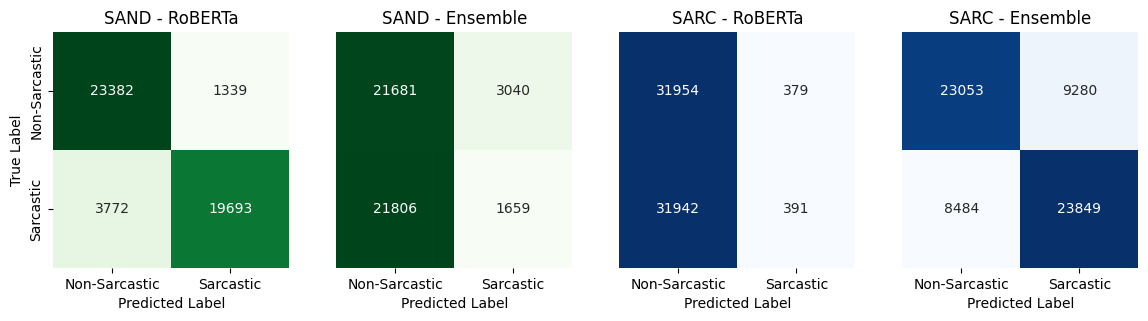

In [22]:
# add all heatmaps to one plot:
fig, axes = plt.subplots(1, 4, figsize=(14, 5.5))

sns.heatmap(sand_rob_matrix, ax=axes[0], cbar=False, square=True, annot=True, fmt='g', cmap="Greens", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=["Non-Sarcastic", "Sarcastic"])
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title('SAND - RoBERTa')

sns.heatmap(sand_ens_matrix, ax=axes[1], cbar=False, square=True, annot=True, fmt='g', cmap="Greens", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=False)
axes[1].set_xlabel('Predicted Label')
axes[1].set_title('SAND - Ensemble')

sns.heatmap(sarc_rob_matrix, ax=axes[2], cbar=False, square=True, annot=True, fmt='g', cmap="Blues", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=False)
axes[2].set_xlabel('Predicted Label')
axes[2].set_title('SARC - RoBERTa')

sns.heatmap(sarc_ens_matrix, ax=axes[3], cbar=False, square=True, annot=True, fmt='g', cmap="Blues", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=False)
axes[3].set_xlabel('Predicted Label')
axes[3].set_title('SARC - Ensemble')

plt.savefig('../images/D4_eval_heatmaps.png')
plt.show()